# **Load Dataset**

In [ ]:
# Install the library that can handle multi-channel TIFF images
!pip install tifffile

In [ ]:
!pip install tensorflow-io -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 27.1 MB/s eta 0:00:00


In [ ]:
import zipfile
import os
from PIL import Image
import matplotlib.pyplot as plt
import random
import tifffile as tiff
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow_io as tfio
import numpy as np
from matplotlib.colors import ListedColormap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_dir = '/content/drive/MyDrive/Cellula Technology/Water Segmentation/Water Segmentation.zip'
zip_ref = zipfile.ZipFile(zip_dir, 'r')
zip_ref.extractall('/content/drive/MyDrive/Cellula Technology/Water Segmentation/Extracted Dataset')
zip_ref.close()

In [ ]:
main_dir = '/content/drive/MyDrive/Cellula Technology/Water Segmentation/Extracted Dataset/data'

In [ ]:
# Get the paths to the image and mask directories
image_dir = os.path.join(main_dir, 'images')
mask_dir = os.path.join(main_dir, 'labels')

# **Data Preprocessing**

In [ ]:
def count_images_in_directory(directory):
  total_images = 0
  for dirpath, dirnames, filenames in os.walk(directory):
    total_images += len(filenames)
  return total_images

In [ ]:
print(f"Number of images: {count_images_in_directory(image_dir)}")
print(f"Number of masks: {count_images_in_directory(mask_dir)}")

Number of images: 306
Number of masks: 306


In [ ]:
import os

# Data Cleaning: Ensure every image has a corresponding mask and vice-versa

# Set this to False to actually delete the files after verifying the dry run.
DRY_RUN = False # Run with True first!

if DRY_RUN:
    print("Starting Data Cleaning (DRY RUN)")
    print("This will only show which files WOULD be deleted.")
else:
    print("Starting Data Cleaning (DELETING FILES)")

# Get the list of filenames from both directories
try:
    image_filenames = os.listdir(image_dir)
    mask_filenames = os.listdir(mask_dir)
    print(f"Initial image count: {len(image_filenames)}")
    print(f"Initial mask count: {len(mask_filenames)}")
except FileNotFoundError as e:
    print(f"Error: A directory was not found. Please check your paths. Details: {e}")
    # Stop execution of this cell if paths are wrong
    raise

# Get the BASE names (without extensions) and put them in sets

image_basenames = {os.path.splitext(f)[0] for f in image_filenames}
mask_basenames = {os.path.splitext(f)[0] for f in mask_filenames}

# Find the base names that are common to both sets
common_basenames = image_basenames.intersection(mask_basenames)
print(f"\nFound {len(common_basenames)} base names with a matching image and mask.")

# Find the files to delete from the IMAGES folder
images_to_delete = []
for img_file in image_filenames:
    base_name = os.path.splitext(img_file)[0]
    if base_name not in common_basenames:
        images_to_delete.append(img_file)

# Find the files to delete from the LABELS (masks) folder
masks_to_delete = []
for mask_file in mask_filenames:
    base_name = os.path.splitext(mask_file)[0]
    if base_name not in common_basenames:
        masks_to_delete.append(mask_file)

# Perform the deletion (or print for dry run)
print("\n Actions to be taken ")

# Process images
if not images_to_delete:
    print("✅ All images have a corresponding mask.")
else:
    print(f"Found {len(images_to_delete)} images to delete:")
    for filename in images_to_delete:
        print(f"  - To Delete: {os.path.join(image_dir, filename)}")
        if not DRY_RUN:
            os.remove(os.path.join(image_dir, filename))

# Process masks
if not masks_to_delete:
    print("✅ All masks have a corresponding image.")
else:
    print(f"Found {len(masks_to_delete)} masks to delete:")
    for filename in masks_to_delete:
        print(f"  - To Delete: {os.path.join(mask_dir, filename)}")
        if not DRY_RUN:
            os.remove(os.path.join(mask_dir, filename))

if not DRY_RUN:
    print("\nFile deletion complete.")

# Verify the final counts
final_image_count = len(os.listdir(image_dir))
final_mask_count = len(os.listdir(mask_dir))

print("\n--- Verification ---")
print(f"Final number of images: {final_image_count}")
print(f"Final number of masks: {final_mask_count}")

if final_image_count == final_mask_count and final_image_count == len(common_basenames):
    print("✅ Success! The number of images and masks now match.")
else:
    print("⚠️ Counts do not match or cleaning was not performed (check DRY_RUN setting).")

Starting Data Cleaning (DELETING FILES)
Initial image count: 306
Initial mask count: 306

Found 306 base names with a matching image and mask.

 Actions to be taken 
✅ All images have a corresponding mask.
✅ All masks have a corresponding image.

File deletion complete.

--- Verification ---
Final number of images: 306
Final number of masks: 306
✅ Success! The number of images and masks now match.


In [ ]:
print(f"Number of images: {count_images_in_directory(image_dir)}")
print(f"Number of masks: {count_images_in_directory(mask_dir)}")

Number of images: 306
Number of masks: 306


# Data Visualization

To make water pop, we can use a spectral index. The most common one for water is the **Normalized Difference Water Index (NDWI)**.
It uses the **Green band** and the **Near-Infrared (NIR)** band in a simple formula:

                                            NDWI = (Green - NIR) / (Green + NIR)

Let's think about what this does:

🟥 For a Water Pixel: 🟥

Green has a medium value, while NIR is very low (absorbed).

So, (Medium - Low) / (Medium + Low) results in a **high positive value**.

🟥 For a Land/Vegetation Pixel: 🟥

Green has a medium value, but NIR is very high (reflected).

So, (Medium - High) / (Medium + High) results in a **strong negative value**.

By calculating this for every pixel, we can create a new image where water is very bright and everything else is very dark.

Displaying True Color vs. NDWI vs. Ground Truth Mask...


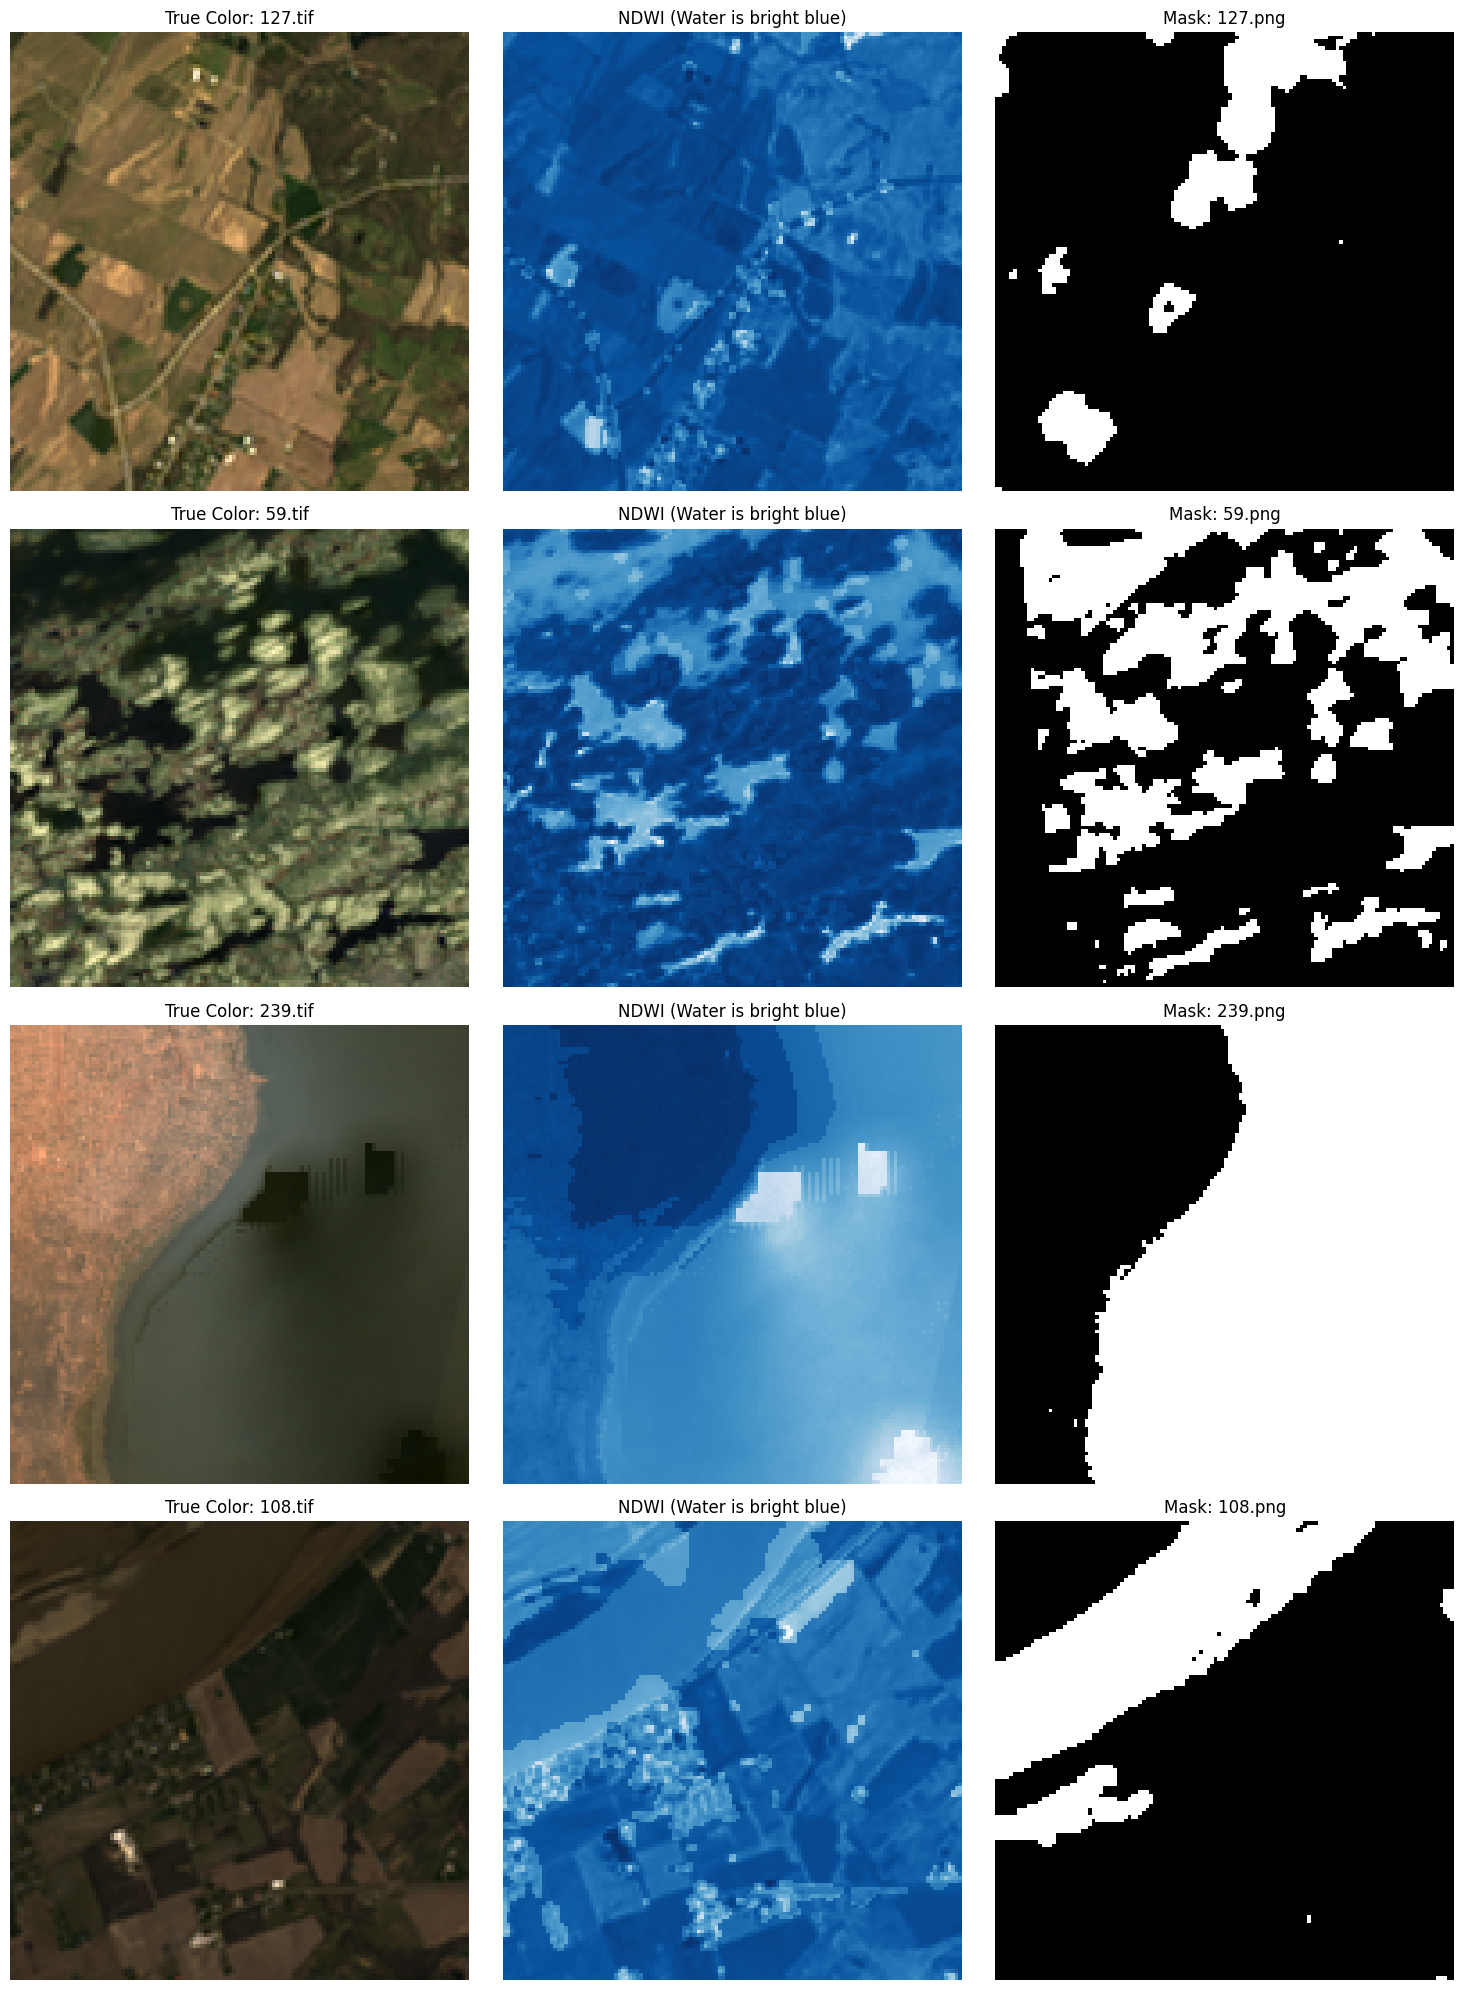

In [ ]:
# True Color vs. NDWI vs. Mask

if 'image_filenames' not in locals() or not image_filenames:
    image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.tif')]

if image_filenames:
    # Select a few random files to display
    num_samples_to_show = 4
    if len(image_filenames) < num_samples_to_show:
        num_samples_to_show = len(image_filenames)

    sample_image_files = random.sample(image_filenames, num_samples_to_show)

    # Let's create a plot with 3 columns now
    fig, axes = plt.subplots(num_samples_to_show, 3, figsize=(15, 5 * num_samples_to_show))
    if num_samples_to_show == 1:
        axes = np.array([axes])

    print("Displaying True Color vs. NDWI vs. Ground Truth Mask...")

    for i, img_filename in enumerate(sample_image_files):
        base_name = os.path.splitext(img_filename)[0]
        mask_filename = f"{base_name}.png"

        img_path = os.path.join(image_dir, img_filename)
        mask_path = os.path.join(mask_dir, mask_filename)

        image_np = tiff.imread(img_path)
        mask_np = np.array(Image.open(mask_path))

        # Re-order if channels are first: (12, H, W) -> (H, W, 12)
        if image_np.shape[0] == 12:
            image_np = np.transpose(image_np, (1, 2, 0))

        # Column 1: True Color Image
        true_color_img = image_np[:, :, [3, 2, 1]] # Bands 4, 3, 2
        # Normalize for display
        min_val, max_val = true_color_img.min(), true_color_img.max()
        if max_val > min_val:
            true_color_img = (true_color_img - min_val) / (max_val - min_val)

        ax_true_color = axes[i, 0]
        ax_true_color.imshow(true_color_img)
        ax_true_color.set_title(f"True Color: {img_filename}")
        ax_true_color.axis('off')

        # Column 2: NDWI Calculation and Visualization
        # Green is Band 3 (index 2), NIR is Band 8 (index 7)
        green_band = image_np[:, :, 2].astype(np.float32)
        nir_band = image_np[:, :, 7].astype(np.float32)

        # Calculate NDWI. Add a small epsilon to avoid division by zero.
        numerator = green_band - nir_band
        denominator = green_band + nir_band + 1e-10
        ndwi = numerator / denominator

        ax_ndwi = axes[i, 1]
        im = ax_ndwi.imshow(ndwi, cmap='Blues') # Use a blue colormap to highlight water
        ax_ndwi.set_title("NDWI (Water is bright blue)")
        ax_ndwi.axis('off')

        # Column 3: Ground Truth Mask
        ax_mask = axes[i, 2]
        ax_mask.imshow(mask_np, cmap='gray')
        ax_mask.set_title(f"Mask: {mask_filename}")
        ax_mask.axis('off')

    plt.tight_layout()
    plt.show()

else:
    print("No image files found.")

# **UNet**

In [ ]:
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

# ---------------------------------------------------------------------------------------------------------------- #

def encoder_block(inputs, num_filters):
    """Encoder block: conv_block -> max_pool."""
    # Returns both the pre-pooled features (f) for the skip connection
    # and the pooled features (p) for the next block.
    f = conv_block(inputs, num_filters)
    p = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(f)
    return f, p

# ---------------------------------------------------------------------------------------------------------------- #

def decoder_block(inputs, skip_features, num_filters):
    """Decoder block: upsample -> concatenate -> conv_block."""
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

# ---------------------------------------------------------------------------------------------------------------- #

def build_unet(input_shape):
    """Build the complete U-Net model."""
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder Path

    f1, p1 = encoder_block(inputs, 64)
    f2, p2 = encoder_block(p1, 128)
    f3, p3 = encoder_block(p2, 256)
    f4, p4 = encoder_block(p3, 512)

    # Bottleneck
    bottleneck = conv_block(p4, 1024)

    # Decoder Path

    d1 = decoder_block(bottleneck, f4, 512)
    d2 = decoder_block(d1, f3, 256)
    d3 = decoder_block(d2, f2, 128)
    d4 = decoder_block(d3, f1, 64)

    # Output Layer
    outputs = tf.keras.layers.Conv2D(1, 1, padding='same', activation='sigmoid')(d4)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='U-Net')
    return model

# ---------------------------------------------------------------------------------------------------------------- #

if __name__ == '__main__':
    model = build_unet(input_shape=(128, 128, 12))
    model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │      6,976 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │     36,928 │ activation_18[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ activation_19[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │    147,584 │ activation_20[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ activation_21[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_23[0][0] 

 Total params: 31,060,481 (118.49 MB)

 Trainable params: 31,048,705 (118.44 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
# DATA PREPARATION FOR TRAINING

# Get the final, cleaned list of all image paths
all_image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.tif')])

# Split the data into training and validation sets (80% train, 20% validation)
train_paths, val_paths = train_test_split(all_image_paths, test_size=0.2, random_state=42)

print(f"Total images: {len(all_image_paths)}")
print(f"Training images: {len(train_paths)}")
print(f"Validation images: {len(val_paths)}")

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 12
BATCH_SIZE = 16

Total images: 306
Training images: 244
Validation images: 62


In [ ]:
def parse_data(image_path_tensor):
    # Convert the tensor path to a regular python string
    image_path = image_path_tensor.numpy().decode('utf-8')

    # Process Image
    # Use tifffile to read the 12-channel image
    image = tiff.imread(image_path)
    # The image might be (12, 128, 128), we need (128, 128, 12)
    if image.shape[0] == IMG_CHANNELS:
        image = np.transpose(image, (1, 2, 0))
    image = image.astype(np.float32)

    # Process Mask
    # Derive mask path and use Pillow
    mask_path = image_path.replace("/images/", "/labels/").replace(".tif", ".png")
    mask = np.array(Image.open(mask_path))
    # Add a channel dimension to the mask (128, 128) -> (128, 128, 1)
    mask = np.expand_dims(mask, axis=-1)
    mask = mask.astype(np.float32)

    return image, mask

def load_and_preprocess(image_path):
    """ Wraps the pure python 'parse_data' function for use in a tf.data pipeline """
    # Use tf.py_function to wrap the parsing logic
    # We must specify the output types (tf.float32 for both image and mask)
    image, mask = tf.py_function(parse_data, [image_path], [tf.float32, tf.float32])

    # We must explicitly set the shapes after using tf.py_function
    image.set_shape([IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    mask.set_shape([IMG_HEIGHT, IMG_WIDTH, 1])

    return image, mask

def create_dataset(paths, batch_size):
    """Creates a tf.data.Dataset pipeline."""
    dataset = tf.data.Dataset.from_tensor_slices(paths)
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(paths))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Create the datasets
train_dataset = create_dataset(train_paths, BATCH_SIZE)
val_dataset = create_dataset(val_paths, BATCH_SIZE)
print("\n✅ tf.data pipelines created successfully using tf.py_function.")


✅ tf.data pipelines created successfully using tf.py_function.


In [ ]:
# Build the model
model = build_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# Define metrics
metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.BinaryIoU(name='iou', target_class_ids=[1])
]

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=metrics
)

# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_water_segmentation_model.keras', save_best_only=True, monitor='val_iou', mode='max'),
    tf.keras.callbacks.EarlyStopping(monitor='val_iou', mode='max', patience=5, restore_best_weights=True)
]

In [ ]:
print("\n--- Starting Model Training ---")
model.summary()

EPOCHS = 25
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks
)
print("\n--- ✅ Training Complete ---")


--- Starting Model Training ---


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 128, 128,  │      6,976 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_36       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 128, 128,  │     36,928 │ activation_36[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_37       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 64, 64,    │          0 │ activation_37[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_8[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_38       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 64, 64,    │    147,584 │ activation_38[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_39       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 32, 32,    │          0 │ activation_39[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_9[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_42[0][0] 

 Total params: 31,060,481 (118.49 MB)

 Trainable params: 31,048,705 (118.44 MB)

 Non-trainable params: 11,776 (46.00 KB)

Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 227s 5s/step - accuracy: 0.4775 - iou: 0.3279 - loss: 0.8043 - precision: 0.3365 - recall: 0.9304 - val_accuracy: 0.8553 - val_iou: 0.5135 - val_loss: 0.5101 - val_precision: 0.6765 - val_recall: 0.6806
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 55s 297ms/step - accuracy: 0.8445 - iou: 0.5532 - loss: 0.4644 - precision: 0.6598 - recall: 0.7767 - val_accuracy: 0.6647 - val_iou: 0.3624 - val_loss: 0.5834 - val_precision: 0.3873 - val_recall: 0.8495
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 472ms/step - accuracy: 0.8818 - iou: 0.6263 - loss: 0.3834 - precision: 0.8057 - recall: 0.7376 - val_accuracy: 0.8678 - val_iou: 0.5536 - val_loss: 0.4855 - val_precision: 0.6952 - val_recall: 0.7310
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 716ms/step - accuracy: 0.9130 - iou: 0.6880 - loss: 0.3006 - precision: 0.8959 - recall: 0.7476 - val_accuracy: 0.8981 - val_iou: 0.6106 - val_loss: 0.4240 - val_precision: 0.8109 - val_recall: 0.7120
Epoch 5/25
16/16 ━━━━━━━━━━━━━━

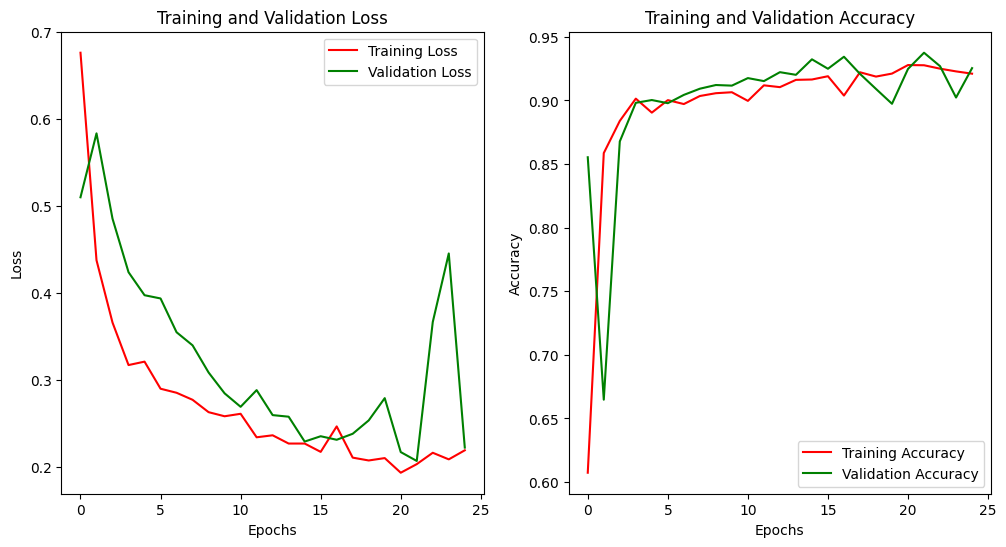

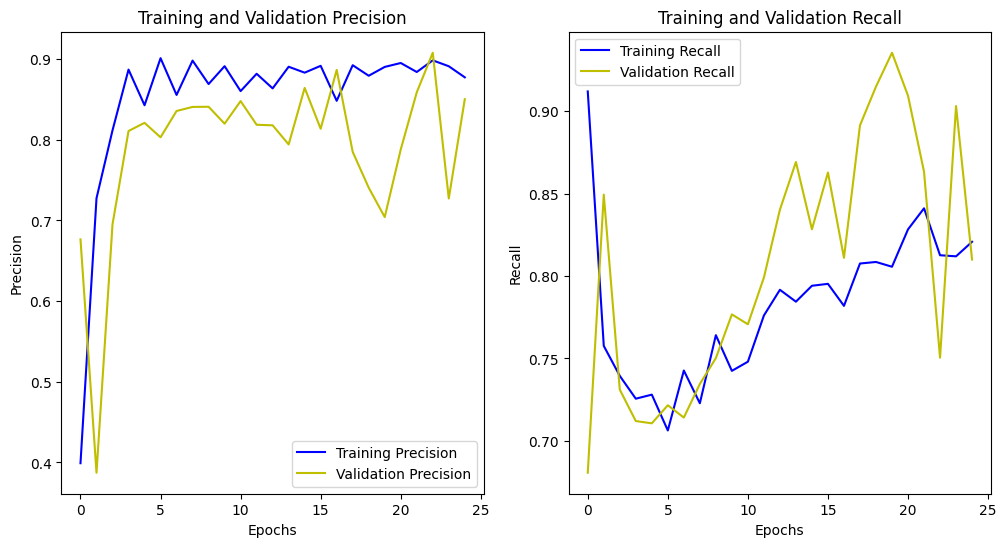

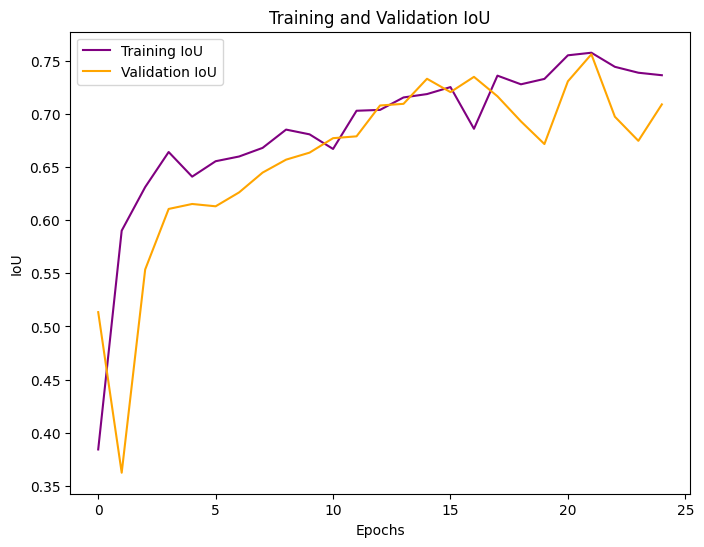

In [ ]:
def plot_training_history(history):
    """Plots training and validation metrics over epochs."""

    history_dict = history.history
    epochs = history.epoch

    # Get metrics
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    precision = history_dict.get('precision', [0] * len(epochs))
    val_precision = history_dict.get('val_precision', [0] * len(epochs))
    recall = history_dict.get('recall', [0] * len(epochs))
    val_recall = history_dict.get('val_recall', [0] * len(epochs))
    iou = history_dict.get('iou', [0] * len(epochs))
    val_iou = history_dict.get('val_iou', [0] * len(epochs))

    # Plot Loss and Accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'g', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot Precision and Recall
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, precision, 'b', label='Training Precision')
    plt.plot(epochs, val_precision, 'y', label='Validation Precision')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, recall, 'b', label='Training Recall')
    plt.plot(epochs, val_recall, 'y', label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.show()

    # Plot IoU
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, iou, 'purple', label='Training IoU')
    plt.plot(epochs, val_iou, 'orange', label='Validation IoU')
    plt.title('Training and Validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()
    plt.show()

# Call the new plotting function
plot_training_history(history)



In [ ]:
# Specify the path to save the model in Google Drive
model_save_path = '/content/drive/MyDrive/Cellula Technology/Water Segmentation/Water_Segmentation_Model_UNET.keras'

# Save the model
model.save(model_save_path)

print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/Cellula Technology/Water Segmentation/Water_Segmentation_Model_UNET.keras


# **FINAL EVALUATION: VISUALIZE SPECIFIC PREDICTIONS VS. GROUND TRUTH**

Loading model from: /content/drive/MyDrive/Cellula Technology/Water Segmentation/Water_Segmentation_Model_UNET.keras
✅ Model loaded successfully.

Looking for specified images...
  ✅ Found: /content/drive/MyDrive/Cellula Technology/Water Segmentation/Extracted Dataset/data/images/104.tif
  ✅ Found: /content/drive/MyDrive/Cellula Technology/Water Segmentation/Extracted Dataset/data/images/120.tif
  ✅ Found: /content/drive/MyDrive/Cellula Technology/Water Segmentation/Extracted Dataset/data/images/298.tif


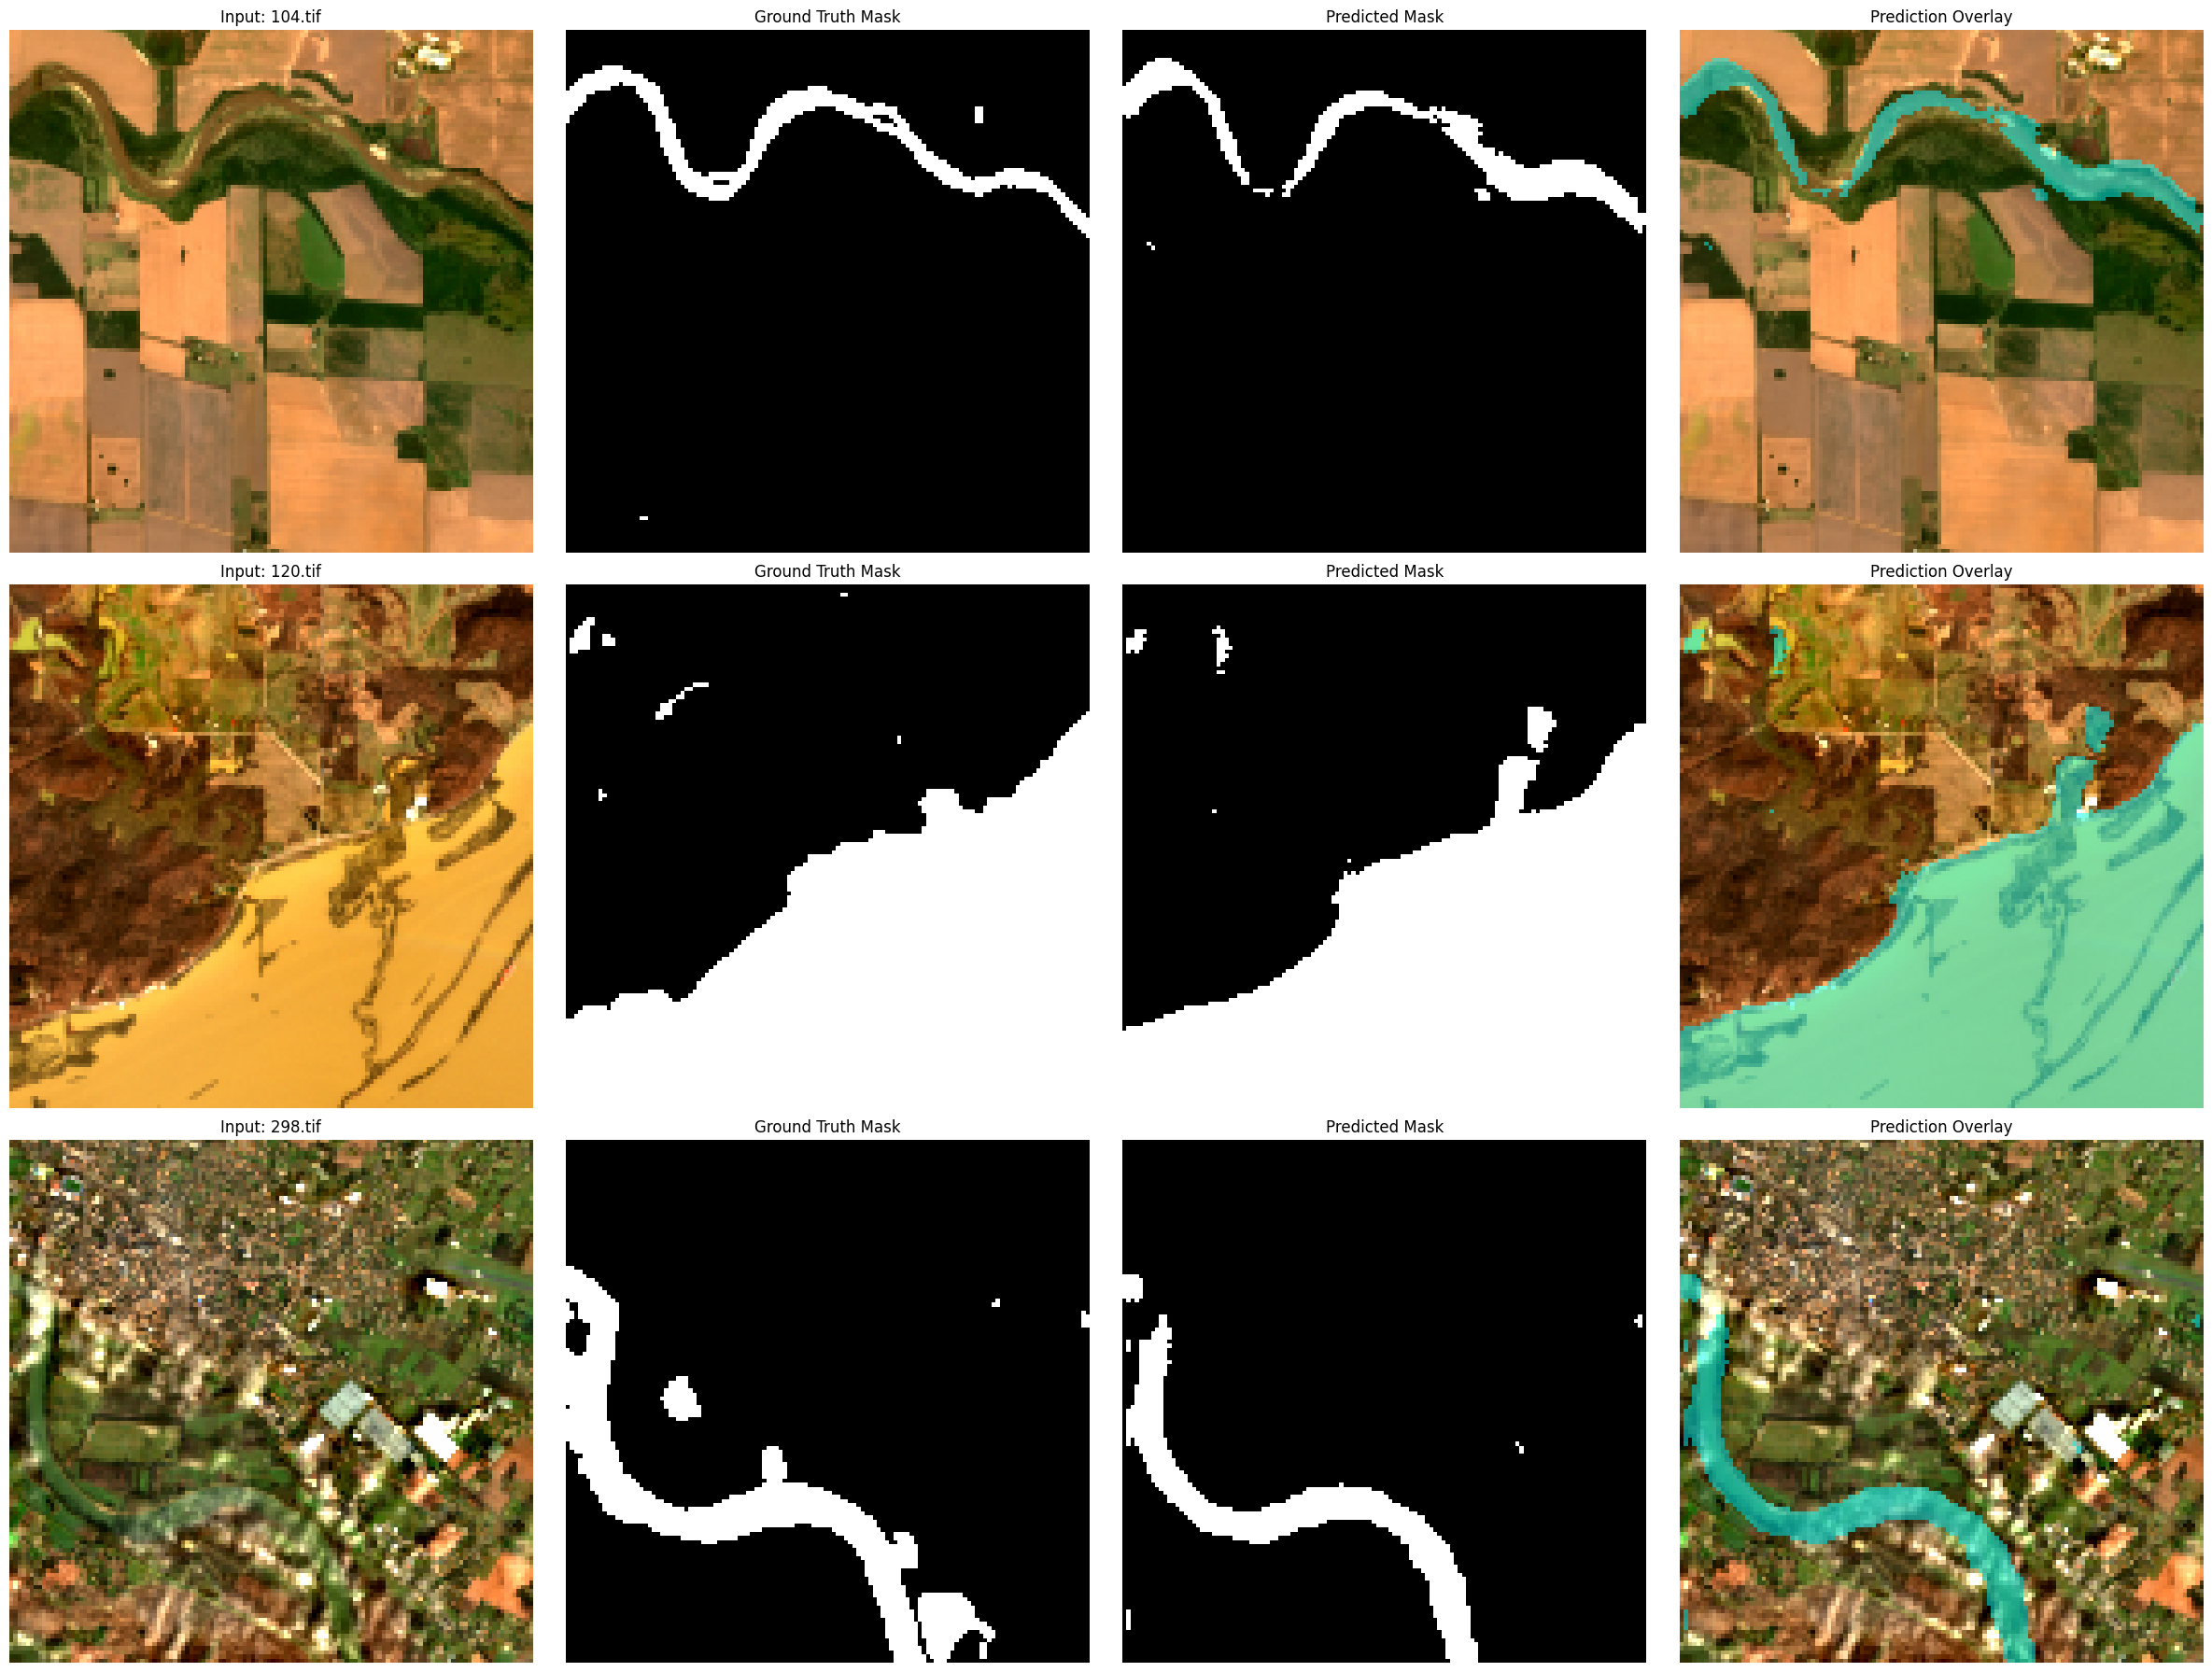

In [ ]:
# Load the best-saved model
model_path = '/content/drive/MyDrive/Cellula Technology/Water Segmentation/Water_Segmentation_Model_UNET.keras'
try:
    print(f"Loading model from: {model_path}")
    model = tf.keras.models.load_model(model_path)
    print("✅ Model loaded successfully.")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    raise

# ---------------------------------------------------------------------------------------------------------------- #

target_basenames = ['104', '120', '298']
test_image_paths = []

print("\nLooking for specified images...")
for basename in target_basenames:
    # Construct the full path to the image
    path = os.path.join(image_dir, f"{basename}.tif")

    # Check if the file actually exists before adding it to our list
    if os.path.exists(path):
        print(f"  ✅ Found: {path}")
        test_image_paths.append(path)
    else:
        print(f"  ⚠️ Warning: Could not find image at {path}. It will be skipped.")

if not test_image_paths:
    print("\n❌ None of the specified images were found. Aborting visualization.")
    # You can stop here if no images were found
    raise FileNotFoundError("Could not find any of the specified images to test.")

num_samples_to_show = len(test_image_paths)

# ---------------------------------------------------------------------------------------------------------------- #

# Create a 4-column subplot for the results
fig, axes = plt.subplots(num_samples_to_show, 4, figsize=(24, 6 * num_samples_to_show))
if num_samples_to_show == 1:
    axes = np.array([axes])

# Loop through each specified test image, predict, and plot

for i, test_image_path in enumerate(test_image_paths):

    # A. Load and preprocess the input image
    input_image = tiff.imread(test_image_path)
    if input_image.shape[0] == IMG_CHANNELS:
        input_image = np.transpose(input_image, (1, 2, 0))

    input_image_for_model = np.expand_dims(input_image.astype(np.float32), axis=0)

    # B. Load the corresponding Ground Truth mask
    ground_truth_path = test_image_path.replace("/images/", "/labels/").replace(".tif", ".png")
    ground_truth_mask = np.array(Image.open(ground_truth_path))

    # C. Make a prediction with the model
    predicted_mask_prob = model.predict(input_image_for_model, verbose=0)

    # D. Post-process the prediction
    threshold = 0.5
    predicted_mask = (predicted_mask_prob[0] > threshold).astype(np.uint8)

    # E. Prepare the True Color image for display
    def normalize_for_display(band_data):
        p2, p98 = np.percentile(band_data, (2, 98))
        clipped_data = np.clip(band_data, p2, p98)
        return (clipped_data - p2) / (p98 - p2 + 1e-8)

    true_color_display = input_image[:, :, [3, 2, 1]].copy()
    true_color_display = normalize_for_display(true_color_display)

    # F. Plot all four results for this sample

    # Column 1: Input Image
    axes[i, 0].imshow(true_color_display)
    axes[i, 0].set_title(f'Input: {os.path.basename(test_image_path)}')
    axes[i, 0].axis('off')

    # Column 2: Ground Truth Mask
    axes[i, 1].imshow(ground_truth_mask, cmap='gray')
    axes[i, 1].set_title('Ground Truth Mask')
    axes[i, 1].axis('off')

    # Column 3: Predicted Mask
    axes[i, 2].imshow(predicted_mask, cmap='gray')
    axes[i, 2].set_title('Predicted Mask')
    axes[i, 2].axis('off')

    # Column 4: Prediction Overlay
    cmap_overlay = ListedColormap(['none', 'cyan'])
    axes[i, 3].imshow(true_color_display)
    axes[i, 3].imshow(predicted_mask, cmap=cmap_overlay, alpha=0.5)
    axes[i, 3].set_title('Prediction Overlay')
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()